# Generate a NSFW triangles using evolutionary algorithm
The generated image is actually pretty safe for work, but with a high open NSFW score.

The code is derived from https://scturtle.me/posts/2014-04-18-ga.html 
It depends on DEAP. 

In [1]:
from open_nsfw import nsfw_score

Using gpu device 0: GeForce GTX 965M (CNMeM is disabled, cuDNN 4007)


In [2]:
from deap import base, creator, tools, algorithms
from PIL import Image, ImageDraw
from random import randint

In [3]:
SIZE_X, SIZE_Y = 256, 256
NUMBER_OF_TRIANGLES = 100
POPULATION = 100
NGEN = 200
POLY = 3

In [4]:
def gen_one_triangle():
    return (tuple([(randint(0, SIZE_X), randint(0, SIZE_Y)) for i in range(POLY)]),
            randint(0,255), randint(0,255), randint(0,255), randint(0,128))

In [5]:
creator.create("Fitness", base.Fitness, weights=(1.0,))  # maximize fitness
creator.create("Individual", list, fitness=creator.Fitness)  # individual class

toolbox = base.Toolbox()
toolbox.register("attr", gen_one_triangle)  # the above function
toolbox.register("individual", tools.initRepeat,  # initialization of individual
                 creator.Individual, toolbox.attr, NUMBER_OF_TRIANGLES)
toolbox.register("population", tools.initRepeat,  # initialization of population
                 list, toolbox.individual)

In [6]:
def triangles_to_image(triangles):
    im = Image.new('RGB', (SIZE_X, SIZE_Y), (255, 255, 255))
    for tri in triangles:
        mask = Image.new('RGBA', (SIZE_X, SIZE_Y))
        draw = ImageDraw.Draw(mask)
        draw.polygon(tri[0], fill=tri[1:])
        im.paste(mask, mask=mask)
        del mask, draw
    return im

def evaluate(t2):
    return nsfw_score(triangles_to_image(t2)),

In [7]:
def mutate(triangles):
    e0 = triangles.fitness.values
    for i in range(10):
        tid = randint(0, NUMBER_OF_TRIANGLES - 1)
        oldt = triangles[tid]

        p = randint(-1, 2 * POLY + 4 - 1)
        if p == -1:
            tid2 = randint(0, NUMBER_OF_TRIANGLES - 1)
            triangles[tid], triangles[tid2] = triangles[tid2], oldt
        else:
            t = list(oldt)
            if p < 2 * POLY:
                points = list(t[0])
                pnt = list(points[p // 2])
                if p%2 == 0:
                    pnt[0] = randint(0, SIZE_X)
                else:
                    pnt[1] = randint(0, SIZE_Y)
                points[p // 2] = tuple(pnt)
                t[0] = tuple(points)
            else:
                p -= 2 * POLY - 1
                t[p] = randint(0, 255)

            triangles[tid] = tuple(t)
   
        if evaluate(triangles) > e0:
            break
        else:
            if p == -1:
                triangles[tid], triangles[tid2] = oldt, triangles[tid]
            else:
                triangles[tid] = oldt
    return triangles,

In [8]:
toolbox.register("evaluate", evaluate)
toolbox.register("mate", tools.cxTwoPoint)  # crossover
toolbox.register("mutate", mutate)  # mutation
toolbox.register("select", tools.selTournament, tournsize=3)

In [9]:
from IPython.display import display, clear_output
import numpy as np
class ipyHOF(tools.HallOfFame):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.last_displayed_fitness = -1
    def insert(self, item):
        if item.fitness.values[0] >= self.last_displayed_fitness+0.001:
            self.last_displayed_fitness = item.fitness.values[0]
            clear_output()
            display(triangles_to_image(item))        
        super().insert(item)

In [10]:
pop = toolbox.population(n=POPULATION)
hof = ipyHOF(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("std", np.std)
stats.register("max", np.max)
stats.register("avg", np.mean)
stats.register("min", np.min)

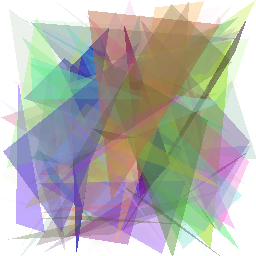

192	47    	0.00439043 	0.990081 	0.987655  	0.9478    
193	59    	0.0019136  	0.989793 	0.988409  	0.974474  
194	48    	0.00145301 	0.990351 	0.988953  	0.975166  
195	63    	0.0883642  	0.990351 	0.978893  	0.11236   
196	61    	0.0440862  	0.990351 	0.98409   	0.556959  
197	60    	0.00699749 	0.990351 	0.988904  	0.923006  
198	59    	0.0296033  	0.990548 	0.986366  	0.693741  
199	50    	0.00114911 	0.990548 	0.990011  	0.980411  
200	56    	0.00447098 	0.990531 	0.989506  	0.959551  


In [11]:
try:
    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=0.5, mutpb=0.1, ngen=NGEN, 
                               stats=stats, halloffame=hof, verbose=True)
except KeyboardInterrupt:
    display(triangles_to_image(hof[0]))

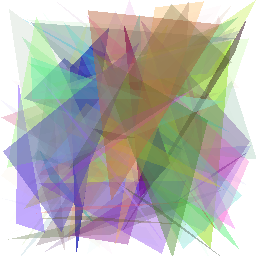

In [12]:
triangles_to_image(hof[0])

In [13]:
triangles_to_image(hof[0]).save('output/nsfw-triangles.png')